# Functional MMD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import math
import pandas as pd
from scipy.stats import gamma
import random
from scipy.interpolate import UnivariateSpline

Different combinations of $(X, Y)$ to evaluate the approximation methods.

## Examples of one to three-dimensional distributions

In [2]:
#X = np.random.normal(0, 1, 256).reshape(-1,1)
#X = np.random.exponential(size=100).reshape(-1,1)
#X = np.random.chisquare(1, size=20).reshape(-1,1)
X = np.random.multivariate_normal([0,1,2], [[1,1,1], [1,1,1], [1,1,1]], size=512)
#X = np.random.randn(20*128).reshape(20,-1)


#Y = np.random.normal(0, 1, 64).reshape(-1,1)
#Y = np.random.exponential(size=256).reshape(-1,1)
#Y = np.random.randn(20*128).reshape(20,-1)
Y = np.random.multivariate_normal([10,11,12], [[11,11,11], [11,11,11], [11,11,11]], size=512)

In [3]:
print(X.shape)
print(Y.shape)

(512, 3)
(512, 3)


## Examples of higher-dimensional distributions

Same for non-stationary processes:

In [2]:
# dimensions
as_is = 12
to_be = 100

# how many samples
samples = 512

# set how far to shift Y (+ shifts to the left, - shifts to the right)
shift_p = 1   # in as_is resolution
shift_par = int(shift_p * to_be / as_is)

print('Shifting for:', shift_par)

Shifting for: 8


[-0.88054106 -0.49707956  1.99143423  0.25715214  0.16249412  0.315536
  0.00502977  1.64017692 -1.05544295  0.92812005  1.75893268 -1.47601339]


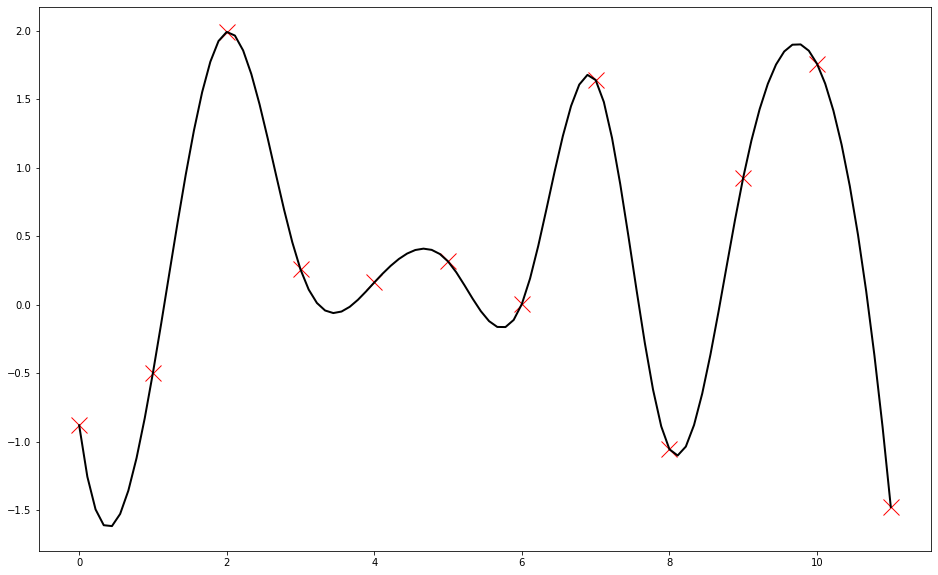

In [6]:
x1 = np.linspace(0, as_is-1, as_is)
time1 = np.random.uniform(-2, 2, as_is)
print(time1)
plt.figure(figsize=(16,10))
plt.plot(time1, 'xr', markersize=16);

# fitting spline to data
spl1 = UnivariateSpline(x1, time1, k=3, s=0)
xs1 = np.linspace(0, 11, to_be)
plt.plot(xs1, spl1(xs1), color='black', linewidth=2);
plt.show()

[ 1.52384039  1.27150041 -1.43091711 -0.9679104   1.40693479  0.87731789
 -0.34282045  0.1416146  -0.68573136  0.10508511 -1.0819798   1.84014962]


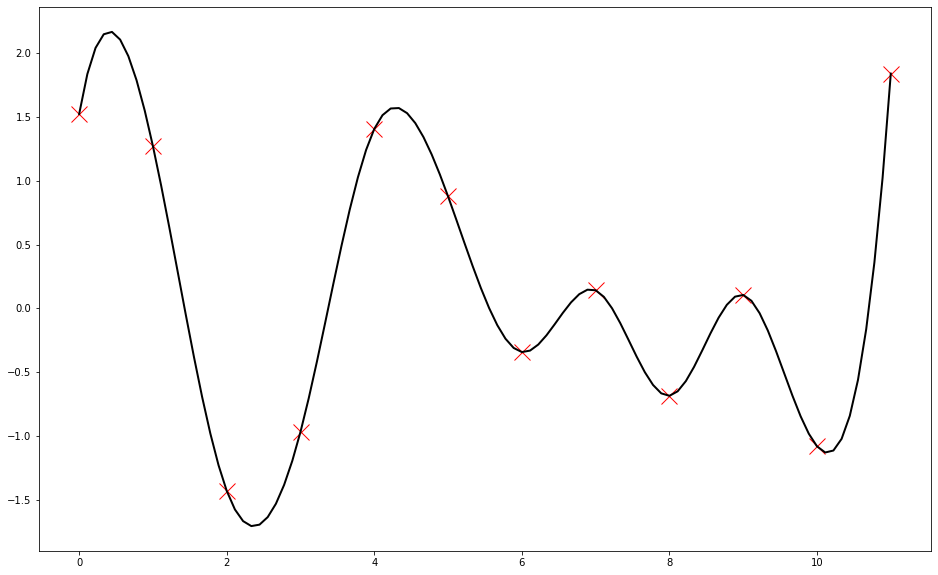

In [7]:
# different and independent
x2 = np.linspace(0, as_is-1, as_is)
time2 = np.random.uniform(-2, 2, as_is)
print(time2)
plt.figure(figsize=(16,10))
plt.plot(time2, 'xr', markersize=16);

# fitting spline to data
spl2 = UnivariateSpline(x2, time2, k=3, s=0)
xs2 = np.linspace(0, 11, to_be)
plt.plot(xs2, spl2(xs2), color='black', linewidth=2);
plt.show()

# Generating high-dimensional distributions satisfying either $H_0: P_X = P_Y$ or $H_1: P_X \neq P_Y$ of MMD

In [9]:
# generating distributions over time

t1d = np.empty((0, samples))
t2d = np.empty((0, samples))

for t in spl1(xs1):
    var = np.random.uniform(0,1,1)
    dist1 = np.random.normal(t, var, samples)
    t1d = np.append(t1d, [dist1], axis=0)
    
    # H0: P_X = P_Y: drawn from same distribution
    #dist2 = np.random.normal(t, var, samples)
    #t2d = np.append(t2d, [dist2], axis=0)

# H1: P_X != P_Y: drawn from different distributions    
for t in spl2(xs2):
    var = np.random.uniform(0,1,1)
    dist2 = np.random.normal(t, var, samples)
    #dist2 = np.random.exponential(var, size=samples)
    #dist2 = np.random.chisquare(var, size=samples)
    #dist2 = np.random.standard_cauchy(size=samples)
    t2d = np.append(t2d, [dist2], axis=0)
    
# shifting time2
if shift_par >= 0:
    t2d = t2d[shift_par:]
elif shift_par < 0:
    t2d = t2d[:shift_par]

time1d = t1d.T
time2d = t2d.T

### Plottings

(512, 100)


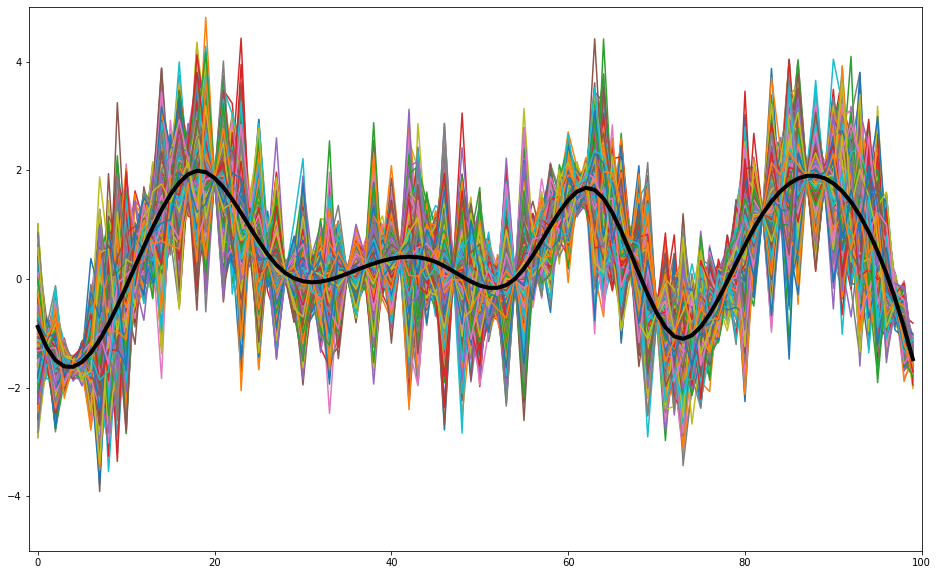

In [10]:
# different dimensions
print(time1d.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, time1d.shape[1], -5, 5])
plt.plot(time1d.T);
plt.plot(spl1(xs1), color='black', linewidth=4);
plt.show()

(512, 92)


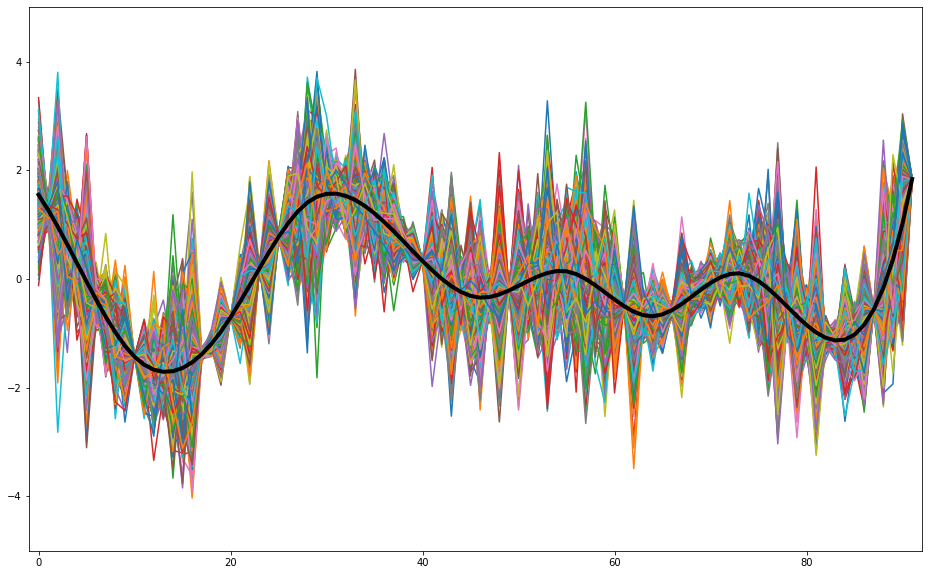

In [12]:
print(time2d.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, time2d.shape[1], -5, 5])
plt.plot(time2d.T);
plt.plot(spl2(xs2)[shift_par:], color='black', linewidth=4);
plt.show()

In [13]:
# same dimensions
if shift_par > 0:
    X = time1d[:, :-shift_par]
    Y = time2d
elif shift_par < 0:
    X = time1d[:, -shift_par:]
    Y = time2d
else:
    X = time1d
    Y = time2d

(512, 92)


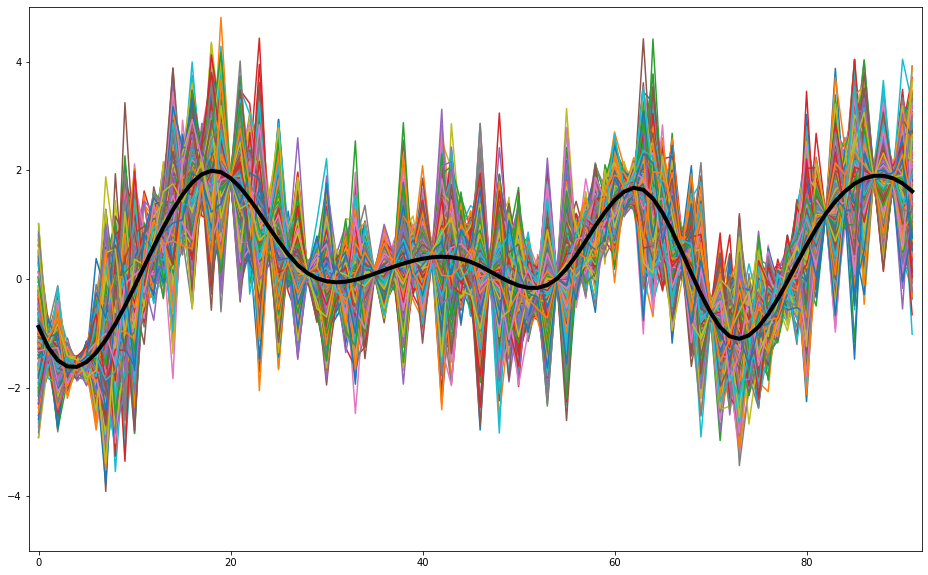

In [17]:
print(X.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, X.shape[1], -5, 5])
plt.plot(X.T);
plt.plot(spl1(xs1)[:-shift_par], color='black', linewidth=4);
plt.show()

(512, 92)


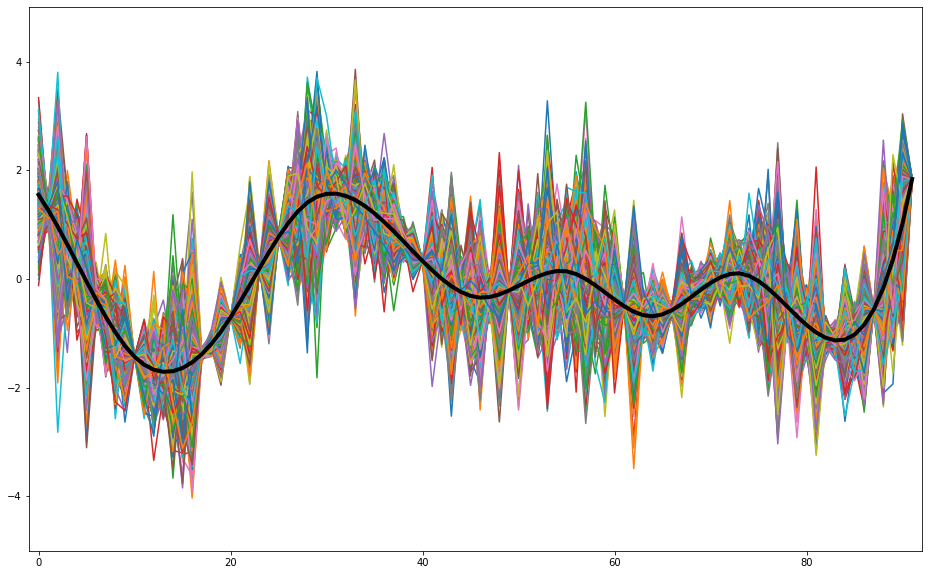

In [18]:
print(Y.shape)
plt.figure(figsize=(16,10))
plt.axis([-1, Y.shape[1], -5, 5])
plt.plot(Y.T);
plt.plot(spl2(xs2)[shift_par:], color='black', linewidth=4);
plt.show()

### Auxiliary functions

In [19]:
# median heuristic for kernel width
def width(Z):
    # compute median for Z
    size_Z = Z.shape[0]
    if size_Z > 100:
        Z_med = Z[0:100]
        size_Z = 100
    else:
        Z_med = Z

    G_Z = np.sum(np.multiply(Z_med, Z_med), axis=1).reshape(-1,1)
    Q_Z = np.tile(G_Z, (1, size_Z))
    R_Z = np.tile(G_Z.T, (size_Z, 1))
    dists_Z = Q_Z + R_Z - 2 * Z_med @ Z_med.T
    distances_Z = (dists_Z - np.tril(dists_Z)).reshape(-1, 1)
    width_Z = np.sqrt(0.5*np.median(distances_Z[distances_Z>0]))
    d_Z = Z.shape[1]
    
    return d_Z * width_Z


# rbf dot product
def rbf_dot(X, Y, width):
    size_X = X.shape
    size_Y = Y.shape
    
    G = np.sum(np.multiply(X, X), axis=1).reshape(-1,1)
    H = np.sum(np.multiply(Y, Y), axis=1).reshape(-1,1)
    
    Q = np.tile(G, (1, size_Y[0]))
    R = np.tile(H.T, (size_X[0], 1))
    
    H = Q + R - 2 * X @ Y.T
    
    # rbf kernel
    K = np.exp(-H/(2*width**2))
    
    return K

# Biased MMD

First, we compute the biased MMD to have a measure how different the two distributions $P_X$ and $P_Y$ are.

In [20]:
# biased MMD estimator
def MMD_b(X, Y, width_X, width_Y):
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    
    # centering matrix
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    return (1/m**2) * np.trace(K @ H @ L @ H)

In [21]:
MMD_b(X, Y, width_X=-1, width_Y=-1)

2.7528693192714997e-11

# Unbiased MMD
Next, we compute the MMD with bias correction.

In [22]:
# unbiased MMD estimator
def MMD_u(X, Y, width_X, width_Y, width_XY):
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    if width_XY == -1:
        width_XY = width(np.concatenate([X, Y]))
    
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    KL = rbf_dot(X, Y, width_XY)
    
    # centering matrix
    H = np.eye(m) - (1/m) * (np.ones((m, m)))
    
    return np.sqrt(1/(m*(m-1)) * (np.sum(K) + np.sum(L) - 2 * np.sum(KL)))

In [23]:
MMD_u(X, Y, -1, -1, -1)

0.029039910868021313

# Statistical test based on MMD
We test statistically whether $\mathcal{H}_0 : P_X = P_Y$ holds true.

## MMD with permutations

In [24]:
def MMD_permutations(X, Y, alpha, width_X, width_Y, width_XY, shuffle): # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    if width_XY == -1:
        width_XY = width(np.concatenate([X, Y]))
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    KL = rbf_dot(X, Y, width_XY)
    
    # test statistic
    stat = 1/m * (np.sum(K + L - KL - KL.T))
    
    Kz = np.concatenate((np.concatenate((K, KL), axis=1), np.concatenate((KL.T, L), axis=1)), axis=0)
    
    # initiating MMD
    MMD_arr = np.zeros(shuffle)
    
    # create permutations by reshuffling L except the main diagonal
    for sh in range(shuffle):
        Kz_s = Kz
        n = ~np.eye(len(Kz_s), dtype=bool)
        Kz_sn = Kz_s[n]
        np.random.shuffle(Kz_sn)
        Kz_s[n] = Kz_sn
        
        K = Kz_s
        
        K = Kz_s[:m, :m]
        L = Kz_s[m:, m:]
        KL = Kz_s[:m, m:]
        
        MMD_arr[sh] = 1/m * (np.sum(K + L - KL - KL.T))
        
    MMD_arr_sort = np.sort(MMD_arr)
    
    # computing 1-alpha threshold
    threshold = MMD_arr_sort[round((1-alpha)*shuffle)]
        
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

## MMD with Gamma distribution approximation

In [25]:
def MMD_gamma(X, Y, alpha, width_X, width_Y, width_XY):    # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    if width_XY == -1:
        width_XY = width(np.concatenate([X, Y]))
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    KL = rbf_dot(X, Y, width_XY)
    
    # test statistic
    stat = 1/m * (np.sum(K + L - KL - KL.T))   
    
    # fitting Gamma distribution to stat
    mMMD = 2/m * (1 - 1/m * np.trace(KL))    # mean under H0
    
    K_diag = K - np.diag(np.diag(K))
    L_diag = L - np.diag(np.diag(L))
    KL_diag = KL - np.diag(np.diag(KL))
    
    varMMD = 2/(m*(m-1)) * 1/(m*(m-1)) * np.sum(np.power((K_diag + L_diag - KL_diag - KL_diag.T), 2))    # variance under H0
    
    al = mMMD**2 / varMMD
    bet = varMMD * m / mMMD
    
    # computing 1-alpha threshold
    threshold = gamma.ppf(1-alpha, al, scale=bet)
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

### Evaluations

In [26]:
# test level alpha = 0.05, 5000 permutations
MMD_permutations(X, Y, 0.05, -1, -1, -1, 5000)

H0 rejected


(0.4309346922666997, 0.0015234269447195296)

In [27]:
# test level alpha = 0.05
MMD_gamma(X, Y, 0.05, -1, -1, -1)

H0 rejected


(0.4309346922666997, 0.0034759231762912257)